# 고혈압 분석 모델

고혈압 판단 조건
1. 'AS1_BPLIE2S_A' 누운 자세 - 2회 sys 측정 평균 140 이상
2. 'AS1_BPLIE2D_A',누운 자세 - 2회 dia 측정 평균 90 이상
3. 'AS1_DrugHtCu' 2번 응답

## @author: sh22h

- year0_NA를 DataFrame으로 불러오고 4개로 나눔
  - binary: 범주형(binary) 변수, 0 / 1 로 변경
  - categoryH0: 계층 없는 범주형(>3) 변수, one-hot-encoding
  - categoryH1: 계층 있는 범주형 변수, 표준화
  - ctn:연속형 변수, 정규화, 표준화 
  - y: 종속변수
    - 'AS1_BPLIE2S_A'
    - 'AS1_BPLIE2D_A'
    - 'AS1_DrugHtCu'
    - hyperTension: 고혈압

- 각각 정규화 또는 표준화한 후 변수는 X 고혈압은 y로 둠
  - 정규화(normalization): 0, 1
  - 표준화(standardization): 평균: 0 표준편차: 1
  - 계층화(quantile transform): 4분위 수

## 학습 모델

- 0차
  - 로컬에서 구현

- 1차
  - 2021-07-20
  - normalize_ctn
  - 
  ```
  model = Sequential()
  model.add(Dense(12, input_dim=52, activation='relu'))  # input layer requires input_dim param
  model.add(Dense(15, activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
  history = model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
  scores = model.evaluate(X_test, y_test)
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))
  ```

- 2차
  - 2021-07-26
  - Decision Tree 구현

- 3차
  - 2021-08-02
  - one-hot encoding 구현

- 4차
  - 2021-08-07
  - 전처리 개선
  - Keras Tunor 사용 준비
  - P1 ~ P4 모델 구현

- 5차
  - 2021-08-08
  - 데이터 결측값 관리
    - TOTALC 유의미한 값: 15개
    - 키, 몸무게 결측값 매우 많음
  - 데이터 결측값 제거
    - TOTALC 삭제
    - KNNImputer로 결측값 채우기
    - https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html#sklearn.impute.KNNImputer

- 6차
  - 2021-08-12
  - 데이터 결측값 관리
    - 변수 모두 포함하라!
    - 범주형: 최빈값
    - 수치형: 평균값(kNN)
    - TOTALC 포함하라
    - 주말까지
  - DicisionTree 보는 법을 해석하라.
  - 모델 정확도 올리기

- 7차
  - 2021-08-23
  - unit 통일
  - dropout 통일
  - 모델 정확도 여전히 안좋음

- 8차
  - 2021-08-24
  - unit, dropout 다시 분리
  - 레이어 늘림

- 9차
  - 2021-08-26
  - 변수 중요도 낮은 변수 일부 제거하고 모델 돌려보기
    - 영향을 조금이라도 주는 것
      1. 'AS1_AGE'
      2. 'AS1_WEIGHT'
      3. 'AS1_B18'
      4. 'AS1_SEX'
      5. 'P3'
      6. 'AS1_B01'
      7. 'AS1_B04'
    - 나머지, 영향 없음.

- 10차
  - 2021-08-29
  - unit 통일
  - dropout 통일
 
- 11차
  - 2021-08-30
  - max_epoch = 10으로 통일

- 12차
  - 데이터셋 변경

- 13차
  - 2021-09-09
  - 데이터셋 변경
    - P1 ~ P4 -> FA1 ~ FA5 
    - columns 54

- 14차
  - 2021-09-13
  - 데이터 추가
    - AS1_WAIST3_A
    - 허리둘레
    - 계층있는 연속형
    - columns: 55

- 15차
  - 2021-09-26
  - 누락 되었던 식품군 F1 ~ F17 데이터 추가
  - 모델 제작에는 사용하지 않음

- 16차
  - 2021-10-01
  - JOBB 추가
  - 키 대신에 BMI 넣음
  - FA를 DP로 변경

- 17차
  - 2022-05-04
  - _1000 변수만으로 모델 학습

- 18차
  - 2022-05-13
  - 혈압을 예측하는 회귀모델 구현
  - _1000 변수 + 원래 쓰던거
  - 77777 to 0
    - AS1_DRDUA: 77777 to 0
    - AS1_HVSMAM: 77777 to 0

  - 그냥 삭제

- 19차
  - 2022-06-01
  - 데이터 describe
    - AS1_B01 있, 1000kcal 나눔
    - AS1_B01 있, 안 나눔
    - AS1_B01 없, 1000kcal 나눔
    - AS1_B01 없, 안 나눔
  
  - 유전적 요인 분석하기
    - 아빠: Father
    - 엄마: Mather
    - 형제자매: Sibling


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


데이터 전처리 과정은 HyperTension_2022-06-01을 참고할 것.

## dataset 분리
- train, test

In [9]:
raw_X = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/X_220607.pkl')
raw_y = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/HyperTension_Returns/y_220606.pkl')

In [10]:
raw_X.info()
raw_y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8149 entries, EPI20_026_2_000004 to EPI20_026_2_010030
Columns: 105 entries, AS1_SEX to AS1_FMLPREL1A_S
dtypes: float64(105)
memory usage: 6.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 8149 entries, EPI20_026_2_000004 to EPI20_026_2_010030
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AS1_DRUGHTCU_FILLNA  8149 non-null   float64
 1   AS1_BPLIE2S_A        8149 non-null   float64
 2   AS1_BPLIE2D_A        8149 non-null   float64
 3   HYPERTENSION         8149 non-null   float64
dtypes: float64(4)
memory usage: 318.3+ KB


In [47]:
# 열 삭제

# # AS1_B01 없, 안 나눔
# X = raw_X.drop(['AS1_B01',
#                 'AS1_B02_1000', 'AS1_B03_1000', 'AS1_B04_1000',
#                 'AS1_B05_1000', 'AS1_B06_1000', 'AS1_B07_1000',
#                 'AS1_B08_1000', 'AS1_B09_1000', 'AS1_B10_1000',
#                 'AS1_B11_1000', 'AS1_B12_1000', 'AS1_B13_1000',
#                 'AS1_B14_1000', 'AS1_B15_1000', 'AS1_B16_1000',
#                 'AS1_B17_1000', 'AS1_B18_1000', 'AS1_B19_1000',
#                 'AS1_B20_1000', 'AS1_B21_1000', 'AS1_B23_1000',
#                 'AS1_B24_1000',
#                 ], axis=1)

# # AS1_B01 없, 1000kcal 나눔
# X = raw_X.drop(columns=['AS1_B01',
#                         'AS1_B02', 'AS1_B03', 'AS1_B04',
#                         'AS1_B05', 'AS1_B06', 'AS1_B07',
#                         'AS1_B08', 'AS1_B09', 'AS1_B10',
#                         'AS1_B11', 'AS1_B12', 'AS1_B13',
#                         'AS1_B14', 'AS1_B15', 'AS1_B16',
#                         'AS1_B17', 'AS1_B18', 'AS1_B19',
#                         'AS1_B20', 'AS1_B21', 'AS1_B23',
#                         'AS1_B24',
#                         ], axis=1)

# AS1_B01 있, 안 나눔
X = raw_X.drop(columns=['AS1_B02_1000', 'AS1_B03_1000', 'AS1_B04_1000',
                        'AS1_B05_1000', 'AS1_B06_1000', 'AS1_B07_1000',
                        'AS1_B08_1000', 'AS1_B09_1000', 'AS1_B10_1000',
                        'AS1_B11_1000', 'AS1_B12_1000', 'AS1_B13_1000',
                        'AS1_B14_1000', 'AS1_B15_1000', 'AS1_B16_1000',
                        'AS1_B17_1000', 'AS1_B18_1000', 'AS1_B19_1000',
                        'AS1_B20_1000', 'AS1_B21_1000', 'AS1_B23_1000',
                        'AS1_B24_1000',
                        ], axis=1)

# # AS1_B01 있, 1000kcal 나눔
# X = raw_X.drop(columns=['AS1_B02', 'AS1_B03', 'AS1_B04',
#                         'AS1_B05', 'AS1_B06', 'AS1_B07',
#                         'AS1_B08', 'AS1_B09', 'AS1_B10',
#                         'AS1_B11', 'AS1_B12', 'AS1_B13',
#                         'AS1_B14', 'AS1_B15', 'AS1_B16',
#                         'AS1_B17', 'AS1_B18', 'AS1_B19',
#                         'AS1_B20', 'AS1_B21', 'AS1_B23',
#                         'AS1_B24',
#                         ], axis=1)

X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8149 entries, EPI20_026_2_000004 to EPI20_026_2_010030
Data columns (total 83 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AS1_SEX           8149 non-null   float64
 1   AS1_STRPHYSJ      8149 non-null   float64
 2   AS1_DRINK_2.0     8149 non-null   float64
 3   AS1_DRINK_3.0     8149 non-null   float64
 4   AS1_SMOKEA_1.0    8149 non-null   float64
 5   AS1_SMOKEA_2.0    8149 non-null   float64
 6   AS1_SMOKEA_3.0    8149 non-null   float64
 7   AS1_EDUA          8149 non-null   float64
 8   AS1_INCOME        8149 non-null   float64
 9   AS1_DRDUA         8149 non-null   float64
 10  AS1_PHYSTB        8149 non-null   float64
 11  AS1_PHYSIT        8149 non-null   float64
 12  AS1_PHYACTL       8149 non-null   float64
 13  AS1_PHYACTM       8149 non-null   float64
 14  AS1_PHYACTH       8149 non-null   float64
 15  AS1_HEALTH        8149 non-null   float64
 16  AS1_AGE         

In [7]:
# y = raw_y['AS1_DRUGHTCU_FILLNA']
# y = raw_y['AS1_BPLIE2S_A']
# y = raw_y['AS1_BPLIE2D_A']
y = raw_y['HYPERTENSION']

display(y)

RID
EPI20_026_2_000004    1.0
EPI20_026_2_000006    1.0
EPI20_026_2_000007    0.0
EPI20_026_2_000010    0.0
EPI20_026_2_000011    1.0
                     ... 
EPI20_026_2_010024    0.0
EPI20_026_2_010026    0.0
EPI20_026_2_010028    0.0
EPI20_026_2_010029    0.0
EPI20_026_2_010030    1.0
Name: HYPERTENSION, Length: 8149, dtype: float64

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=415)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6519, 83) (1630, 83) (6519,) (1630,)


## 모델 제작 XGBoost Classifiaction


HYPERTENSION 0 / 1

In [13]:
import xgboost as xgb
from xgboost import plot_importance

In [49]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [50]:
# Define hyperparameters
params_xgb = {"max_depth": 5,
              "eta": 0.1,
              'objective': 'binary:logistic',
              'eval_metric':'logloss',
              'early_stopping': 32
              }

num_round = 400

### train()

In [51]:
wlist = [(dtrain, 'train'), (dtest, 'eval')]

xgb_model = xgb.train(params=params_xgb, dtrain=dtrain, num_boost_round=num_round, evals=wlist)
xgb_model

[0]	train-logloss:0.655934	eval-logloss:0.657058
[1]	train-logloss:0.625266	eval-logloss:0.628661
[2]	train-logloss:0.599722	eval-logloss:0.604888
[3]	train-logloss:0.577939	eval-logloss:0.585348
[4]	train-logloss:0.558995	eval-logloss:0.568012
[5]	train-logloss:0.543106	eval-logloss:0.554805
[6]	train-logloss:0.528953	eval-logloss:0.542607
[7]	train-logloss:0.516839	eval-logloss:0.53271
[8]	train-logloss:0.506629	eval-logloss:0.524266
[9]	train-logloss:0.497362	eval-logloss:0.516192
[10]	train-logloss:0.489545	eval-logloss:0.510287
[11]	train-logloss:0.482088	eval-logloss:0.504691
[12]	train-logloss:0.475766	eval-logloss:0.500306
[13]	train-logloss:0.470072	eval-logloss:0.496331
[14]	train-logloss:0.464485	eval-logloss:0.492862
[15]	train-logloss:0.459807	eval-logloss:0.489661
[16]	train-logloss:0.455141	eval-logloss:0.487637
[17]	train-logloss:0.450714	eval-logloss:0.485254
[18]	train-logloss:0.447101	eval-logloss:0.483297
[19]	train-logloss:0.443696	eval-logloss:0.48188
[20]	train-l

### predict()

In [52]:
pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10], 3))

[0.248 0.196 0.033 0.031 0.058 0.082 0.063 0.162 0.146 0.307]


In [53]:
preds = [1 if x > 0.5 else 0 for x in pred_probs]
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [55]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
  cf = confusion_matrix(y_test, pred)
  acc = accuracy_score(y_test, pred)
  prc = precision_score(y_test, pred)
  recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred_proba)

  print(cf)
  print(f"""
  정확도 {format(acc, '.4f')}
  정밀도 {format(prc, '.4f')}
  재현율 {format(recall, '.4f')}
  F1     {format(f1, '.4f')}
  AUC    {format(roc_auc, '.4f')}
  """)

In [56]:
get_clf_eval(y_test, preds, pred_probs)

[[1169   89]
 [ 295   77]]

  정확도 0.7644
  정밀도 0.4639
  재현율 0.2070
  F1     0.2862
  AUC    0.6996
  


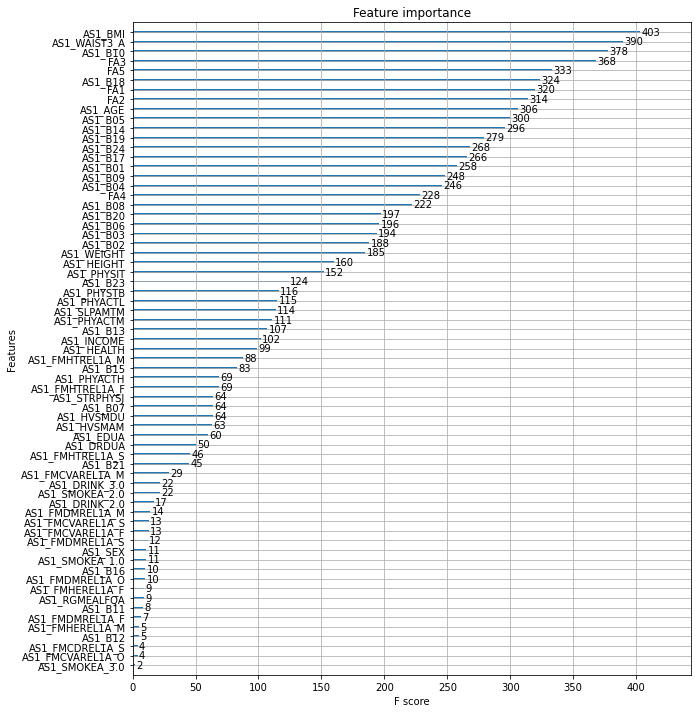

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

## 모델 제작 XGBoost Regression
https://www.kaggle.com/code/harvindarjunrai/predicting-house-prices-v1/notebook

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Define a function for each metric
# R²
def rsqr_score(test, pred):
    """Calculate R squared score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        R squared score 
    """
    r2_ = r2_score(test, pred)
    return r2_


# RMSE
def rmse_score(test, pred):
    """Calculate Root Mean Square Error score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_


# Print the scores
def print_score(test, pred, model):
    """Print calculated score 

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the regressor name
        print the R squared score
        print Root Mean Square Error score
    """

    print(f"- Regressor: {model}")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")

In [ ]:
model_xgb_opt = XGBRegressor(colsample_bytree = xgbr_cv.best_params_["colsample_bytree"],
                             learning_rate = xgbr_cv.best_params_["learning_rate"],
                             max_depth = xgbr_cv.best_params_["max_depth"],
                             n_estimators = xgbr_cv.best_params_["n_estimators"])

model_xgb_opt.fit(X_train, y_train)
y_pred_xgb_opt = model_xgb_opt.predict(X_test)
print_score(y_test, y_pred_xgb_opt, "XGBoost")

[18:14:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
- Regressor: XGBoost
R²: 0.23443704727259929
RMSE: 0.25175056594755973



## 모델 제작 DNN

In [ ]:
UNITS = 32
EPOCH = 128
DROPOUT = 0.05
LEARNINGRATE = 0.01

In [ ]:
# class ClearTrainingOutput(keras.callbacks.Callback):
#   def on_train_end(*args, **kwargs):
#     IPython.display.clear_output(wait = True)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# 검증 데이터 손실이 3회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)

mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
# 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# 검증 데이터 손실이 3회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)

nodes = [8, 16, 32, 40, 48, 56, 64]
scoreList = []

In [ ]:
scoreList = []

for i in nodes:
  model = Sequential()
  model.add(Dense(i, activation='relu'))  # input layer requires input_dim param
  
  model.add(Dropout(DROPOUT))
  model.add(Dense(i, activation='relu'))

  model.add(Dropout(DROPOUT))
  model.add(Dense(i, activation='relu'))

  # model.add(Dropout(DROPOUT))
  # model.add(Dense(i, activation='relu'))

  # model.add(Dropout(DROPOUT))
  # model.add(Dense(i, activation='relu'))

  # model.add(Dropout(DROPOUT))
  # model.add(Dense(i, activation='relu'))

  model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1
  
  model.compile(loss="binary_crossentropy",
                optimizer = Adam(learning_rate = LEARNINGRATE),
                metrics=['accuracy'])
  
  history = model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.2, callbacks=es)
  scores = model.evaluate(X_test, y_test)
  scoreList.append(scores[1])
  
  print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

for x in scoreList:
  print(f"{format(x, '.3f')}")

Epoch 20: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4805 - accuracy: 0.7718
accuracy: 77.18%
Epoch 21: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4906 - accuracy: 0.7583
accuracy: 75.83%
Epoch 17: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4849 - accuracy: 0.7798
accuracy: 77.98%
Epoch 13: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4943 - accuracy: 0.7564
accuracy: 75.64%
Epoch 26: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4934 - accuracy: 0.7699
accuracy: 76.99%
Epoch 24: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.5053 - accuracy: 0.7706
accuracy: 77.06%
Epoch 24: early stopping
51/51 [==============================] - 0s 2ms/step - loss: 0.4791 - accuracy: 0.7804
accuracy: 78.04%
0.772
0.758
0.780
0.756
0.770
0.771
0.780


In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu'))  # input layer requires input_dim param

model.add(Dropout(DROPOUT))
model.add(Dense(64, activation='relu'))

model.add(Dropout(DROPOUT))
model.add(Dense(64, activation='relu'))

model.add(Dropout(DROPOUT))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))  # sigmoid instead of relu for final probability between 0 and 1

model.compile(loss="binary_crossentropy",
              optimizer = Adam(learning_rate = LEARNINGRATE),
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_split=0.2, callbacks=es)
scores = model.evaluate(X_test, y_test)

print("%s: %.3f%%" % (model.metrics_names[1], scores[1]))

Epoch 1/100
163/163 [==============================] - 2s 4ms/step - loss: 0.5233 - accuracy: 0.7686 - val_loss: 0.5525 - val_accuracy: 0.7607
Epoch 2/100
163/163 [==============================] - 1s 3ms/step - loss: 0.5074 - accuracy: 0.7714 - val_loss: 0.4871 - val_accuracy: 0.7439
Epoch 3/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4968 - accuracy: 0.7701 - val_loss: 0.5188 - val_accuracy: 0.7278
Epoch 4/100
163/163 [==============================] - 1s 3ms/step - loss: 0.4925 - accuracy: 0.7712 - val_loss: 0.5070 - val_accuracy: 0.7607
Epoch 5/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4878 - accuracy: 0.7693 - val_loss: 0.4855 - val_accuracy: 0.7531
Epoch 6/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4885 - accuracy: 0.7710 - val_loss: 0.4991 - val_accuracy: 0.7669
Epoch 7/100
163/163 [==============================] - 0s 3ms/step - loss: 0.4926 - accuracy: 0.7726 - val_loss: 0.4873 - val_accuracy: 0.7623

In [ ]:
model.save('my_model.h5')

In [ ]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_154 (Dense)           (None, 64)                3456      
                                                                 
 dropout_98 (Dropout)        (None, 64)                0         
                                                                 
 dense_155 (Dense)           (None, 64)                4160      
                                                                 
 dropout_99 (Dropout)        (None, 64)                0         
                                                                 
 dense_156 (Dense)           (None, 64)                4160      
                                                                 
 dropout_100 (Dropout)       (None, 64)                0         
                                                                 
 dense_157 (Dense)           (None, 64)              

In [ ]:
from sklearn.tree import DecisionTreeClassifier

ht_tree = DecisionTreeClassifier(max_depth=5)
ht_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [ ]:
ht_tree.score(X_test, y_test)

0.758282208588957

In [ ]:
from sklearn.tree import export_graphviz
import graphviz
export_graphviz(ht_tree, out_file="tree.dot",
                class_names='FT',
                feature_names=X.columns,
                impurity=True, filled=True)

In [ ]:
!ls

drive  my_model.h5  sample_data  tree.dot


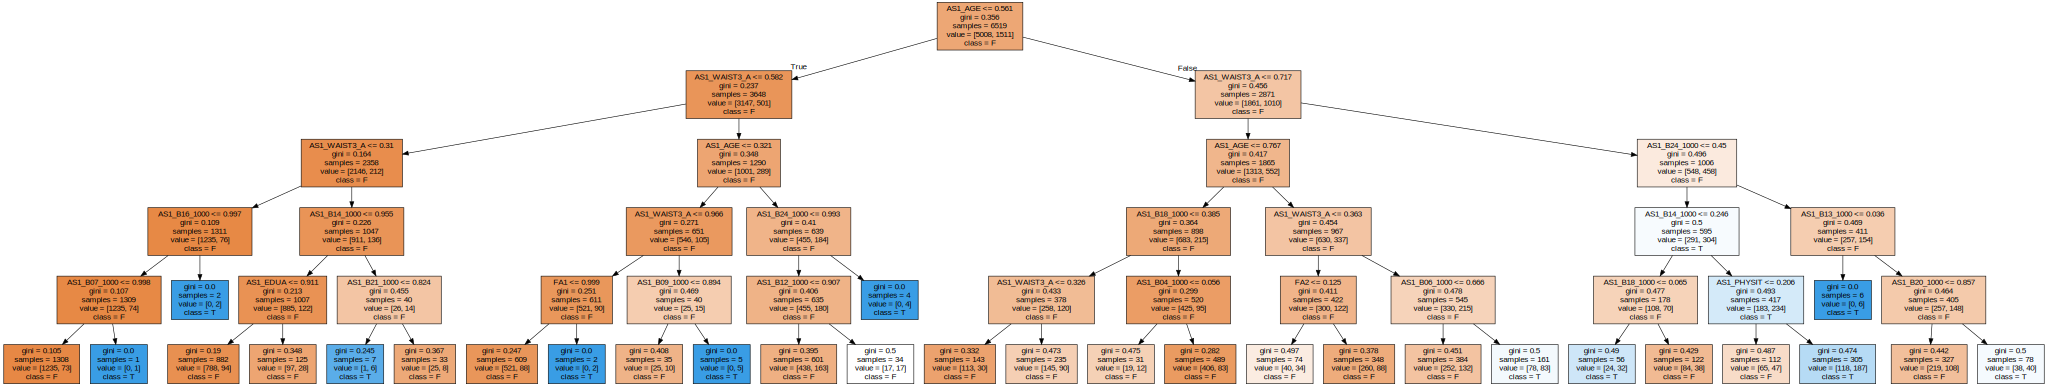

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()
    
graphviz.Source(dot_graph, filename='tree.png',format='png')

In [ ]:
# Define hyperparameters
tuned_parameters_xgb = {"max_depth": [3],
                        "colsample_bytree": [0.3, 0.7],
                        "learning_rate": [0.01, 0.05, 0.1],
                        "n_estimators": [100, 500, 1000]}

# GridSearch
xgbr_cv = GridSearchCV(estimator=XGBRegressor(),
                       param_grid=tuned_parameters_xgb,
                       cv=5,
                       n_jobs=-1,
                       verbose=1)

# fit the GridSearch on train set
xgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgbr_cv.best_params_}\n")
print(f"Best R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[18:12:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}

Best R²: 0.19239226561742367
